# Sample from a univariate Gaussian distribution using a GAN
In this notebook, we'll train a GAN to (try to) sample from a 1-dimensional Gaussian distribution.

First, some imports:

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

# vegans imports:
from vegans import MMGAN
from vegans.utils import plot_losses

ngpu = 0

Now we'll define some variables. `nz` is the size of the noise vector (input of the generator), while `mu` and `sigma` are the two parameters of the Gaussian distribution we'll try to learn.

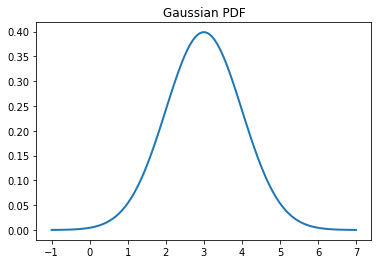

In [118]:
nz = 5

mu = 3.
sigma = 1.

def plot_gaussian(mu, sigma):
    x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)
    y = (1 / (np.sqrt(2 * np.pi * np.power(sigma, 2)))) * \
        (np.power(np.e, -(np.power((x - mu), 2) / (2 * np.power(sigma, 2)))))
    plt.plot(x, y, lw=2)
    plt.title('Gaussian PDF');
    
plot_gaussian(mu, sigma)

Now we'll define a `torch.utils.data.DataLoader` that is just serving some samples of our Gaussian (with dummy labels):

In [52]:
class GaussianDataset(Dataset):
    def __getitem__(self, idx):
        return np.array([sigma * np.random.randn() + mu]).astype(np.float32), 0

    def __len__(self):
        return 10000
    
dataset = GaussianDataset()
dataloader = DataLoader(dataset, batch_size=16)

Let's check and see if the empirical distribution of our samples matches our desired PDF:

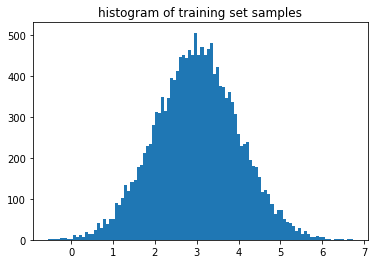

In [117]:
vals = []
for _ in range(1000):
    vals += list(next(iter(dataloader))[0].flatten())
plt.hist(vals, bins=100)
plt.title('histogram of training set samples');

OK looks good!

## Definition of a Generator and a Discriminator:
Here we'll define simple networks with 2 fully connected layers and a ReLU nonlinearity:

In [105]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(nz, 10)
        self.fc2 = nn.Linear(10, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(1, 10)
        self.fc2 = nn.Linear(10, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x
    
critic = Critic()
generator = Generator()

Let's see the samples that our (untrained) generator outputs:

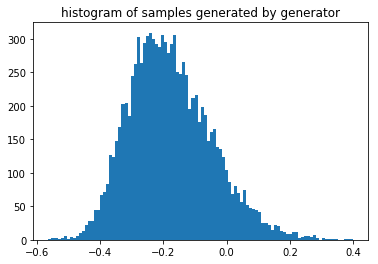

In [106]:
def plot_generator_distribution(generator_):
    """ Try the generator on a noise mini-batch
    """
    z = torch.from_numpy(np.random.randn(10000, nz).astype(np.float32))
    samples = generator_(z)
    plt.hist(samples.detach().numpy().flatten(), bins=100)
    plt.title('histogram of samples generated by generator');
    
plot_generator_distribution(generator)

They are pretty far from our desired Gaussian; so let's train a GAN to try getting closer.
## Training a GAN
Here we'll use the [classic minimax GAN](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf), training for 30 "epochs" (although an epoch doesn't mean much since we are generating pseudo-random data), and saving 1024 samples along training.

In [107]:
gan = MMGAN(generator, critic, dataloader, ngpu=ngpu, nr_epochs=30, nz=nz, fixed_noise_size=1024, print_every=1000)

device: cpu


In [108]:
gan.train();

[1/30][375/625](- iter/s)	Loss_D: 1.02982807	Loss_G: 0.68134868	D(x): 0.77997971	D(G(z1)): 0.52044064	D(G(z2)): 0.52020210
[3/30][125/625](700.537 iter/s)	Loss_D: 1.47975326	Loss_G: 0.72605711	D(x): 0.45310572	D(G(z1)): 0.48806247	D(G(z2)): 0.48772839
[4/30][500/625](704.849 iter/s)	Loss_D: 1.40130925	Loss_G: 0.81882191	D(x): 0.44202042	D(G(z1)): 0.44125399	D(G(z2)): 0.44125316
[6/30][250/625](696.024 iter/s)	Loss_D: 1.39405191	Loss_G: 0.67283863	D(x): 0.50646788	D(G(z1)): 0.51011574	D(G(z2)): 0.51030207
[8/30][0/625](657.927 iter/s)	Loss_D: 1.38901138	Loss_G: 0.69589096	D(x): 0.49766469	D(G(z1)): 0.49898425	D(G(z2)): 0.49864921
[9/30][375/625](671.828 iter/s)	Loss_D: 1.38376021	Loss_G: 0.69220889	D(x): 0.50174105	D(G(z1)): 0.50044626	D(G(z2)): 0.50048685
[11/30][125/625](704.231 iter/s)	Loss_D: 1.38551593	Loss_G: 0.69845587	D(x): 0.49752572	D(G(z1)): 0.49711165	D(G(z2)): 0.49735567
[12/30][500/625](696.192 iter/s)	Loss_D: 1.38611245	Loss_G: 0.69629323	D(x): 0.49930048	D(G(z1)): 0.4992

## Inspecting Results
Let's have a look again at the distribution of samples coming from the generator:

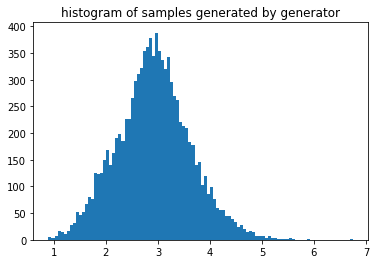

In [120]:
plot_generator_distribution(generator)

Not bad! It looks fairly close to our original Gaussian (note: it's probably possible to do better...).

We can also have a look at the evolution of the discriminator and generator losses:

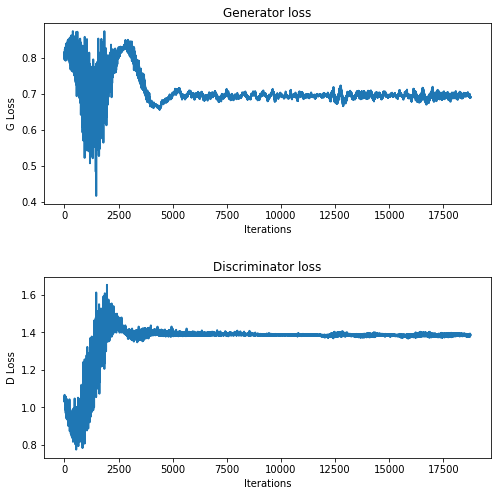

In [119]:
samples_l, D_losses, G_losses = gan.get_training_results()

plot_losses(G_losses, D_losses)

Finally, let us see how the distribution evolved over training, by plotting the histograms of our 1024 samples over training:

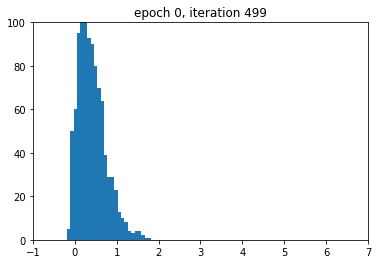

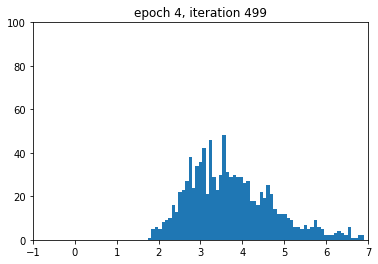

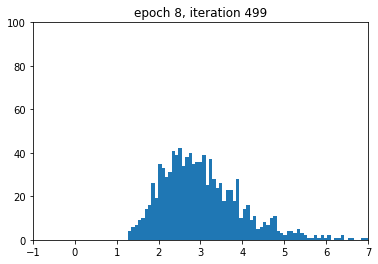

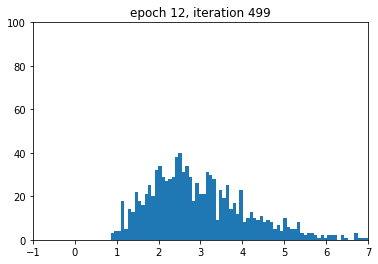

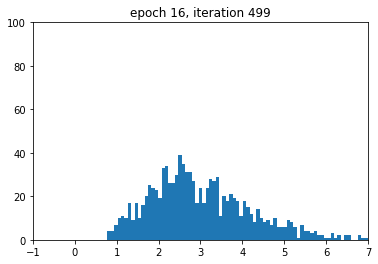

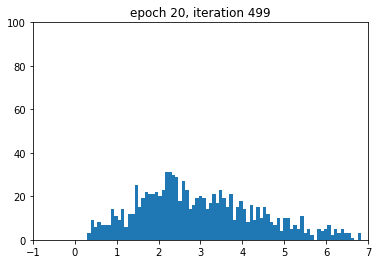

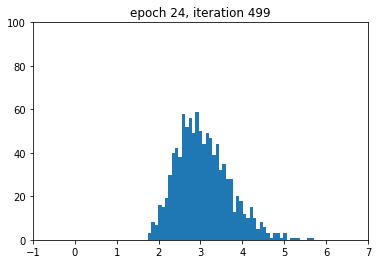

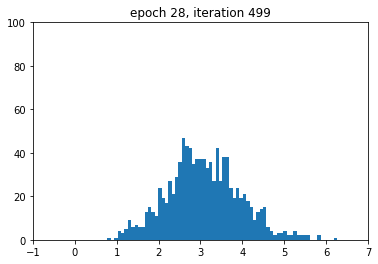

In [121]:
for i, (t, samples) in enumerate(samples_l.items()):
    if i % 5 != 0:
        continue
    plt.figure()
    plt.hist(np.array(samples).flatten(), bins=np.linspace(mu - 4*sigma, mu + 4*sigma, 100))
    plt.axis([mu-4*sigma, mu+4*sigma, 0, 100])
    plt.title('epoch {}, iteration {}'.format(t[0], t[1]));